In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the RiverAtlas Shapefile
shapefile_path = "/home/bsurya/Projects/AIR-Zones/data/HydroRIVERS_v10_as_shp/HydroRIVERS_v10_as_shp/HydroRIVERS_v10_as.shp"

dataframe = gpd.read_file(shapefile_path)

In [3]:
dataframe.head()

,HYRIV_ID,NEXT_DOWN,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,ORD_STRA,ORD_CLAS,ORD_FLOW,HYBAS_L12,geometry
0,40000001,40000019,40017702,2.48,3056.6,6.9,14.93,14.9,0,0.133,1,5,7,4121166050,"LINESTRING (124.60417 55.87708, 124.61875 55.8..."
1,40000002,40000019,40017702,1.23,3056.8,6.0,12.76,12.8,0,0.120,1,6,7,4121166050,"LINESTRING (124.63542 55.88333, 124.63542 55.8..."
2,40000003,40000015,40017702,1.26,3052.8,7.4,11.80,11.8,0,0.100,1,7,7,4120080930,"LINESTRING (125.24583 55.85417, 125.23958 55.8..."
3,40000004,40000015,40017702,1.30,3052.6,7.9,2.17,24.9,0,0.195,2,6,7,4120080930,"LINESTRING (125.26042 55.84375, 125.23958 55.8..."
4,40000005,40000004,40017702,0.69,3054.1,6.4,10.84,10.8,0,0.090,1,7,8,4120080930,"LINESTRING (125.26042 55.85000, 125.26042 55.8..."


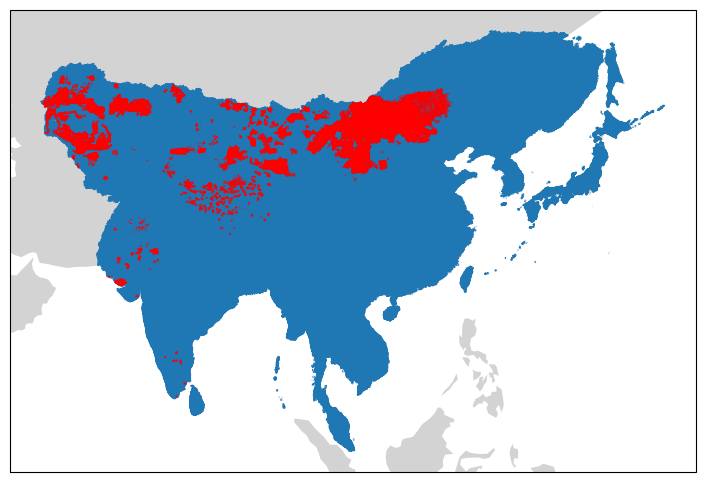

In [9]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a figure and subplot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add land and ocean background
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot the RiverAtlas data
dataframe.plot(ax=ax)
# Plot the RiverAtlas data
dataframe[dataframe.DIS_AV_CMS==0].plot(color='red',ax=ax)

# Display the plot
plt.show()

<Axes: >

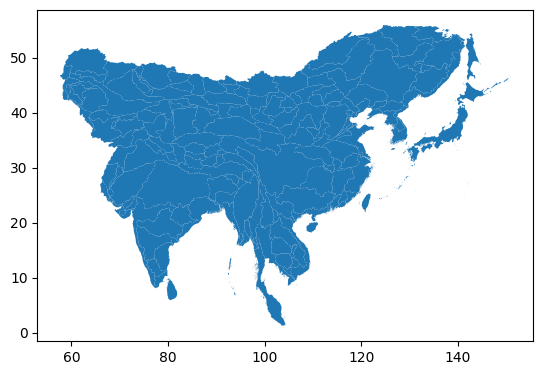

In [11]:
lev04 = gpd.read_file("data/hybas_as_lev01-06_v1c/hybas_as_lev04_v1c.shp")
lev04.plot()

<Axes: >

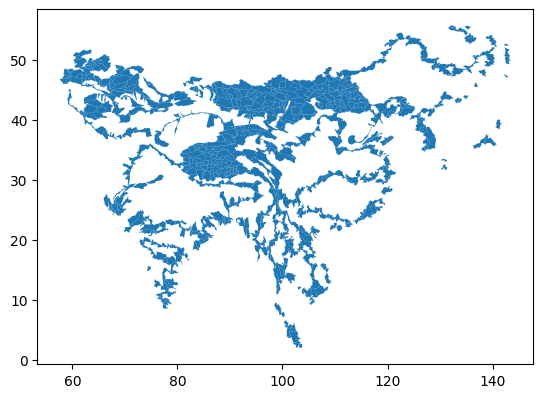

In [24]:
lev06 = gpd.read_file("data/hybas_as_lev01-06_v1c/hybas_as_lev06_v1c.shp")
lev06[lev06.ORDER==1].plot()

In [23]:
lev06.head()

,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry
0,4060000010,0,4060000010,4060000010,0.0,0.0,892.0,892.0,421010,0,1,0,1,"POLYGON ((135.95000 55.42500, 135.95216 55.424..."
1,4060000080,0,4060000080,4060000080,0.0,0.0,2796.2,2796.2,421020,0,0,1,2,"POLYGON ((135.31667 55.63750, 135.31883 55.638..."
2,4060000090,0,4060000090,4060000090,0.0,0.0,690.1,690.1,421030,0,1,0,3,"POLYGON ((135.11250 55.17083, 135.11285 55.173..."
3,4060000160,0,4060000160,4060000160,0.0,0.0,87.2,60970.8,421041,0,0,1,4,"POLYGON ((135.26667 54.70417, 135.27026 54.703..."
4,4060084980,4060000160,4060000160,4060000160,10.2,10.2,3635.9,56995.4,421043,0,0,1,5,"POLYGON ((134.39583 55.13750, 134.39619 55.139..."


/home/bsurya/packages/mambaforge/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


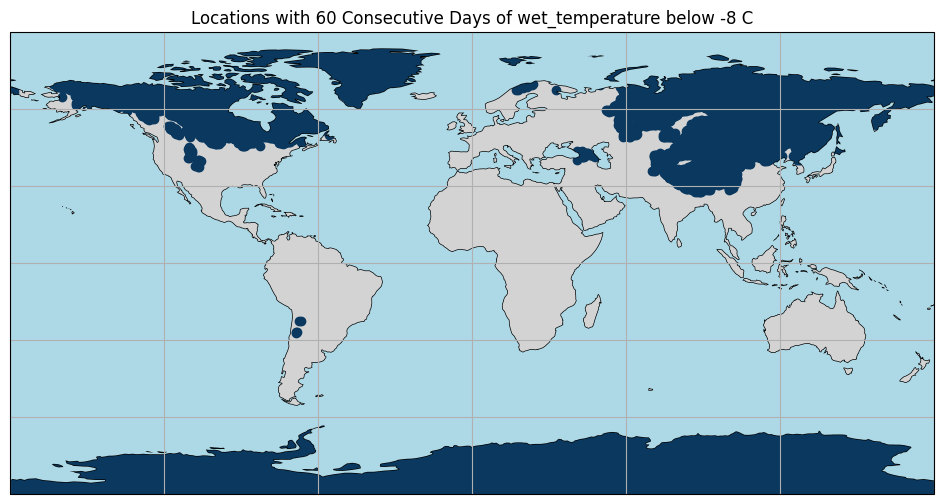

In [37]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd

# Load the netCDF file
year = '2019'
dataset = xr.open_dataset('data/wettasmin_W5E5v2.0_'+year+'.nc')
var = 'wet_temperature'
# Define the temperature threshold
threshold = - 8

# Set the window size
window_size = 60

# Extract the necessary variables
lat = dataset['lat']
lon = dataset['lon']
temperature = dataset[var]

# Filter the dataset to the year 2001
year_dataset = dataset.sel(time=year)[var]

# Create a mask indicating if the temperature is below the threshold
mask = year_dataset < threshold

# Count the number of consecutive days below the threshold
consecutive_days = np.zeros_like(mask, dtype=int)
consecutive_days[0] = mask[0].astype(int)

for i in range(1, len(mask)):
    consecutive_days[i] = mask[i].astype(int) * (consecutive_days[i-1] + 1)

# Find the maximum consecutive days for each latitude and longitude
max_consecutive_days = np.max(consecutive_days, axis=0)

# Reshape the max_consecutive_days array based on latitude and longitude dimensions
reshaped_max_consecutive_days = max_consecutive_days.reshape(len(lat), len(lon))

# Find the latitude and longitude where the maximum consecutive days are greater than the window size
indices = np.where(reshaped_max_consecutive_days > window_size)
latitudes = lat[indices[0]]
longitudes = lon[indices[1]]

# Create a GeoDataFrame from the selected locations
geometry = gpd.points_from_xy(longitudes, latitudes)
gdf = gpd.GeoDataFrame(geometry=geometry)

# Set the coordinate reference system (CRS) of the GeoDataFrame
gdf.crs = {'init': 'epsg:4326'}

# Save the GeoDataFrame as a shapefile
output_shapefile = 'data/selected_locations.shp'
gdf.to_file(output_shapefile)

# Plot the map
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add land and ocean background
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Add map features
ax.coastlines()
ax.gridlines()

# Plot the selected locations
ax.scatter(longitudes, latitudes, color='#0a385f', marker='o', transform=ccrs.PlateCarree(), zorder=1)

# Add land and ocean background
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=2)

# Set the plot extent to cover the entire world
ax.set_global()

# Set plot title and labels
title = 'Locations with {} Consecutive Days of {} below {} C'.format(window_size, var, threshold)
ax.set_title(title)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Save the plot as a PNG image
output_image = 'figs/' + title + '.png'
plt.savefig(output_image, bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


ValueError: aspect must be finite and positive 

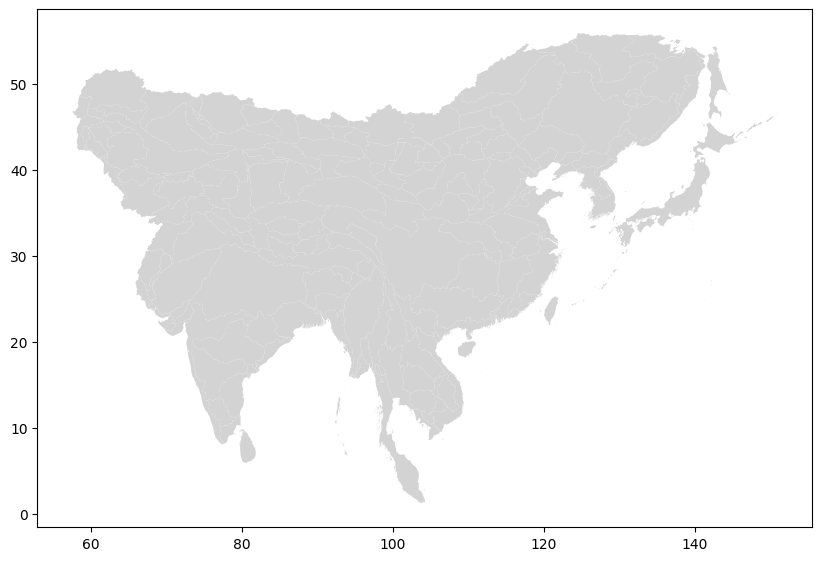

In [16]:
import geopandas as gpd

# Read the first shapefile
shapefile1 = gpd.read_file('data/selected_locations.shp')


# Read the second shapefile
shapefile2 = lev04

shapefile3= dataframe[dataframe.DIS_AV_CMS>=0]

shapefile1 = gpd.overlay(shapefile1, shapefile3, how='intersection')

# Perform intersection
intersection = gpd.overlay(shapefile1, shapefile2, how='intersection')

# Plot the intersection on shapefile 2 as background
fig, ax = plt.subplots(figsize=(10, 10))

# Plot shapefile 2 as background
shapefile2.plot(ax=ax, color='lightgray')

# Plot the intersection
intersection.plot(ax=ax, color='red')


# Set plot title and labels
ax.set_title('Intersection of Shapefile 1 and Shapefile 2')

# Show the plot
plt.show()
